<a href="https://colab.research.google.com/github/wiz124/chem169-git/blob/main/Li_Harry_RID_016_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
#Exercise 0
#!pip install -q biopython
from Bio import SeqIO
import requests
from io import StringIO

Prot_IDs=['P04406','P10599','P68871','P04637']
def getFasta(ID):
    url = f"https://rest.uniprot.org/uniprotkb/{ID}.fasta"
    response = requests.get(url)
    response.raise_for_status()
    fasta_data = StringIO(response.text)

    for seq_record in SeqIO.parse(fasta_data, "fasta"):
      print(len(seq_record.seq))
      return str(seq_record.seq)


query_dict={}
for id in Prot_IDs:
  query_dict[id]=getFasta(id)

print(query_dict)


335
105
147
393
{'P04406': 'MGKVKVGVNGFGRIGRLVTRAAFNSGKVDIVAINDPFIDLNYMVYMFQYDSTHGKFHGTVKAENGKLVINGNPITIFQERDPSKIKWGDAGAEYVVESTGVFTTMEKAGAHLQGGAKRVIISAPSADAPMFVMGVNHEKYDNSLKIISNASCTTNCLAPLAKVIHDNFGIVEGLMTTVHAITATQKTVDGPSGKLWRDGRGALQNIIPASTGAAKAVGKVIPELNGKLTGMAFRVPTANVSVVDLTCRLEKPAKYDDIKKVVKQASEGPLKGILGYTEHQVVSSDFNSDTHSSTFDAGAGIALNDHFVKLISWYDNEFGYSNRVVDLMAHMASKE', 'P10599': 'MVKQIESKTAFQEALDAAGDKLVVVDFSATWCGPCKMIKPFFHSLSEKYSNVIFLEVDVDDCQDVASECEVKCMPTFQFFKKGQKVGEFSGANKEKLEATINELV', 'P68871': 'MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH', 'P04637': 'MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRE

In [9]:
#Exercise 1
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Blast import NCBIXML


recordlst=[]
for key,value in query_dict.items():
  record=SeqRecord(Seq(value),id=key)
  recordlst.append(record)
with open('query_proteins.fasta', "w") as output:
  queryfasta = SeqIO.write(recordlst,output, "fasta")

with open("blast_results.xml") as f:
    blast_records = list(NCBIXML.parse(f))  # one record per query protein

alignment_dict={}
for record in blast_records:
    print(f"\n{record.query}")

    query_id = record.query.split(' ')[0]
    hits = {}
    for rank, alignment in enumerate(record.alignments[:10]):
        hsp = alignment.hsps[0]
        uid = alignment.hit_def.split('|')[1]
        hits[uid] = {
            'blast_rank': rank,
            'e_value':    hsp.expect,
            'pct_id':     hsp.identities / hsp.align_length,
        }
        alignment_dict[query_id]=hits
print(alignment_dict)



P04406 <unknown description>

P10599 <unknown description>

P68871 <unknown description>

P04637 <unknown description>
{'P04406': {'P0A9B2': {'blast_rank': 0, 'e_value': 1.40553e-161, 'pct_id': 0.6606060606060606}, 'P0A9B6': {'blast_rank': 1, 'e_value': 1.24916e-82, 'pct_id': 0.375}}, 'P10599': {'P0AA25': {'blast_rank': 0, 'e_value': 7.02746e-14, 'pct_id': 0.3522727272727273}, 'P0AGG4': {'blast_rank': 1, 'e_value': 1.07126e-13, 'pct_id': 0.3235294117647059}, 'P77395': {'blast_rank': 2, 'e_value': 2.36368e-06, 'pct_id': 0.25274725274725274}}}


In [12]:
#Exercise 2
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import h5py

def compute_similarity(query_embeddings,db_embeddings):

  query_matrix=np.array([query_embeddings[id] for id in Prot_IDs])

  db_ids=list(db_embeddings.keys())
  db_matrix=np.array([db_embeddings[id] for id in db_ids])

  comp=cosine_similarity(query_matrix,db_matrix)
  return comp

def getProteinName(hit_id):
  for record in SeqIO.parse('ecoli.fasta', "fasta"):
    if hit_id in str(record.id):
      return str(record.id).split('|')[2]

def tophits(comparison,sequences,db_embeddings):
  query_order=Prot_IDs
  db_ids=list(db_embeddings.keys())

  result=[]

  for query_idx,id in enumerate(query_order):
    hits=np.argsort(comparison[query_idx])[::-1][:10].tolist()

    for i, idx in enumerate(hits):
      hit_id=db_ids[idx]
      similarity=comparison[query_idx][idx]
      sequence=sequences[hit_id]

      name=getProteinName(hit_id)

      result.append({
          'query': id,
          'rank': i,
          'ref_id': hit_id,
          'name': name,
          'similarity': similarity,
          'sequence': sequence
    })
  return result

with h5py.File('query_proteins.h5', 'r') as file:
    query_embeddings={}
    for name in file.keys():
        query_embeddings[name]=file[name][:]
with h5py.File('per-protein.h5', 'r') as file:
  db_embeddings={}
  for name in file.keys():
    db_embeddings[name]=file[name][:]

print(query_embeddings)
similarities=compute_similarity(query_embeddings,db_embeddings)

sequences={}
for record in SeqIO.parse('ecoli.fasta', 'fasta'):
  parse=record.id.split('|')
  if len(parse)>=2:
    uniprot_id=parse[1]
  else:
    uniprot_id=parse[0]
  sequences[uniprot_id]=str(record.seq)

results=tophits(similarities,sequences,db_embeddings)
resultdf=pd.DataFrame(results)
display(resultdf)

{'P04406': array([ 0.01534 ,  0.113   ,  0.004246, ..., -0.01727 , -0.002478,
        0.0843  ], dtype=float16), 'P04637': array([ 0.01562 ,  0.03845 ,  0.02039 , ..., -0.0414  , -0.00926 ,
       -0.015465], dtype=float16), 'P10599': array([ 0.0892 ,  0.09875, -0.03683, ..., -0.0736 ,  0.02391,  0.02037],
      dtype=float16), 'P68871': array([ 0.1073  ,  0.06525 ,  0.010925, ...,  0.04044 , -0.05927 ,
        0.076   ], dtype=float16)}


,query,rank,ref_id,name,similarity,sequence
0,P04406,0,P0A9B2,G3P1_ECOLI,0.927050,MTIKVGINGFGRIGRIVFRAAQKRSDIEIVAINDLLDADYMAYMLK...
1,P04406,1,P61889,MDH_ECOLI,0.821558,MKVAVLGAAGGIGQALALLLKTQLPSGSELSLYDIAPVTPGVAVDL...
2,P04406,2,P0CE48,EFTU2_ECOLI,0.808739,MSKEKFERTKPHVNVGTIGHVDHGKTTLTAAITTVLAKTYGGAARA...
3,P04406,3,P0CE47,EFTU1_ECOLI,0.808287,MSKEKFERTKPHVNVGTIGHVDHGKTTLTAAITTVLAKTYGGAARA...
4,P04406,4,P0AGE9,SUCD_ECOLI,0.777293,MSILIDKNTKVICQGFTGSQGTFHSEQAIAYGTKMVGGVTPGKGGT...
5,P04406,5,P0A6P9,ENO_ECOLI,0.759750,MSKIVKIIGREIIDSRGNPTVEAEVHLEGGFVGMAAAPSGASTGSR...
6,P04406,6,P08200,IDH_ECOLI,0.752024,MESKVVVPAQGKKITLQNGKLNVPENPIIPYIEGDGIGVDVTPAML...
7,P04406,7,P0A817,METK_ECOLI,0.746620,MAKHLFTSESVSEGHPDKIADQISDAVLDAILEQDPKARVACETYV...
8,P04406,8,P0A6F5,CH60_ECOLI,0.746416,MAAKDVKFGNDARVKMLRGVNVLADAVKVTLGPKGRNVVLDKSFGA...
9,P04406,9,P0A6A6,LEUC_ECOLI,0.743258,MAKTLYEKLFDAHVVYEAENETPLLYIDRHLVHEVTSPQAFDGLRA...


In [13]:
#Exercise 3
from scipy.stats import spearmanr
def emb_top10(resultdf):
    output = {}
    for query_id, grp in resultdf.groupby('query'):
        output[query_id] = {row['ref_id']: int(row['rank']) for _, row in grp.iterrows()}
    return output

emb_dict   = emb_top10(resultdf)
summary_rows = []

for query_id in alignment_dict:
        blast_ids = set(alignment_dict[query_id].keys())
        emb_ids   = set(emb_dict.get(query_id, {}).keys())

        intersection = blast_ids & emb_ids
        union        = blast_ids | emb_ids
        overlap      = len(intersection)
        jaccard      = overlap / len(union) if union else 0.0

        # Rank correlation for shared hits
        spearman_r = np.nan
        p_val      = np.nan
        if len(intersection) >= 3:          # need at least 3 points
            shared = sorted(intersection)
            b_ranks = [alignment_dict[query_id][uid]['blast_rank'] for uid in shared]
            e_ranks = [emb_dict[query_id][uid]                 for uid in shared]
            res = spearmanr(b_ranks, e_ranks)
            spearman_r, p_val = res.statistic, res.pvalue

        print(f"{query_id:<12} {overlap:>4}/10   {jaccard:>7.3f}   {spearman_r:>10.3f}   {p_val:>9.4f}")

        # Per-protein detailed breakdown
        print(f"\n  Shared proteins ({overlap}):")
        for uid in sorted(intersection):
            br = alignment_dict[query_id][uid]['blast_rank']
            er = emb_dict[query_id].get(uid, '–')
            ev = alignment_dict[query_id][uid]['e_value']
            pi = alignment_dict[query_id][uid]['pct_id']
            print(f"    {uid}  BLAST rank {br+1:>2}  |  Emb rank {er+1 if isinstance(er,int) else er:>2}  "
                  f"|  E-val {ev:.2e}  |  %ID {pi:.1%}")

        blast_only = blast_ids - emb_ids
        emb_only   = emb_ids   - blast_ids
        if blast_only:
            print(f"  BLAST-only ({len(blast_only)}): {', '.join(sorted(blast_only))}")
        if emb_only:
            print(f"  Embedding-only ({len(emb_only)}): {', '.join(sorted(emb_only))}")
        print()

        summary_rows.append({
            'query':        query_id,
            'blast_hits':   len(blast_ids),
            'emb_hits':     len(emb_ids),
            'overlap':      overlap,
            'jaccard':      round(jaccard, 3),
            'spearman_r':   round(spearman_r, 3) if not np.isnan(spearman_r) else 'N/A',
            'p_value':      round(p_val, 4)       if not np.isnan(p_val)      else 'N/A',
        })

summary_df = pd.DataFrame(summary_rows)
display(summary_df)

P04406          1/10     0.091          nan         nan

  Shared proteins (1):
    P0A9B2  BLAST rank  1  |  Emb rank  1  |  E-val 1.41e-161  |  %ID 66.1%
  BLAST-only (1): P0A9B6
  Embedding-only (9): P08200, P0A6A6, P0A6F5, P0A6P9, P0A817, P0AGE9, P0CE47, P0CE48, P61889

P10599          2/10     0.182          nan         nan

  Shared proteins (2):
    P0AA25  BLAST rank  1  |  Emb rank  1  |  E-val 7.03e-14  |  %ID 35.2%
    P0AGG4  BLAST rank  2  |  Emb rank  2  |  E-val 1.07e-13  |  %ID 32.4%
  BLAST-only (1): P77395
  Embedding-only (8): P0ABQ2, P0AC69, P0AC81, P0AE08, P0AE52, P0AEQ3, P61949, P69441



,query,blast_hits,emb_hits,overlap,jaccard,spearman_r,p_value
0,P04406,2,10,1,0.091,N/A,N/A
1,P10599,3,10,2,0.182,N/A,N/A


In [15]:
#Exercise 4
print("=" * 70)
print("DISAGREEMENT ANALYSIS")
print("=" * 70)

disagreements = {}
for query_id in alignment_dict:
    blast_ids = set(alignment_dict[query_id].keys())
    emb_ids   = set(emb_dict.get(query_id, {}).keys())

    blast_only = blast_ids - emb_ids
    emb_only   = emb_ids   - blast_ids

    disagreements[query_id] = {"blast_only": sorted(blast_only),
                                "emb_only":   sorted(emb_only)}

    print(f"\nQuery: {query_id}")
    print(f"  BLAST-only hits  (in BLAST top-10 but NOT embedding top-10): {sorted(blast_only)}")
    print(f"  Embedding-only hits (in embedding top-10 but NOT BLAST top-10): {sorted(emb_only)}")

import requests, time

def uniprot_summary(uid):
    url = f"https://rest.uniprot.org/uniprotkb/{uid}.json"
    try:
        r = requests.get(url, timeout=10)
        r.raise_for_status()
        data = r.json()
        name = data.get("proteinDescription", {}).get("recommendedName", {}).get("fullName", {}).get("value", "N/A")
        comments = data.get("comments", [])
        func = next((c["texts"][0]["value"] for c in comments if c.get("commentType") == "FUNCTION"), "N/A")
        return name, func[:300]
    except Exception as e:
        return "N/A", str(e)

all_disagreement_ids = set()
for v in disagreements.values():
    all_disagreement_ids.update(v["blast_only"])
    all_disagreement_ids.update(v["emb_only"])

print("\n" + "=" * 70)
print("UNIPROT ANNOTATIONS FOR DISAGREEMENT PROTEINS")
print("=" * 70)

uid_info = {}
for uid in sorted(all_disagreement_ids):
    name, func = uniprot_summary(uid)
    uid_info[uid] = {"name": name, "function": func}
    print(f"\n{uid}")
    print(f"  Name    : {name}")
    print(f"  Function: {func}")
    time.sleep(0.3)


DISAGREEMENT ANALYSIS

Query: P04406
  BLAST-only hits  (in BLAST top-10 but NOT embedding top-10): ['P0A9B6']
  Embedding-only hits (in embedding top-10 but NOT BLAST top-10): ['P08200', 'P0A6A6', 'P0A6F5', 'P0A6P9', 'P0A817', 'P0AGE9', 'P0CE47', 'P0CE48', 'P61889']

Query: P10599
  BLAST-only hits  (in BLAST top-10 but NOT embedding top-10): ['P77395']
  Embedding-only hits (in embedding top-10 but NOT BLAST top-10): ['P0ABQ2', 'P0AC69', 'P0AC81', 'P0AE08', 'P0AE52', 'P0AEQ3', 'P61949', 'P69441']

UNIPROT ANNOTATIONS FOR DISAGREEMENT PROTEINS

P08200
  Name    : Isocitrate dehydrogenase [NADP]
  Function: Catalyzes the oxidative decarboxylation of isocitrate to 2-oxoglutarate and carbon dioxide with the concomitant reduction of NADP(+)

P0A6A6
  Name    : 3-isopropylmalate dehydratase large subunit
  Function: Catalyzes the isomerization between 2-isopropylmalate and 3-isopropylmalate, via the formation of 2-isopropylmaleate

P0A6F5
  Name    : Chaperonin GroEL
  Function: Together w

Exercise 4

Q1: BLAST detects hits through direct sequence identity, thus even a short highly conserved sequence can produce a low e value. If an E.coli protein shares a well conserved 20 residue stretch with the query but is diverged in sequence, BLAST will score it highly while embeddings may not place it near the query in embedding space.

Q2: PLM are trained to predict masked amino acids in context which confer implicit information of biochemical and structural grammar of proteins. Two proteins can converge on similar folds and functions through completely different sequences. BLAST would give a low score but PLM can recognize residue level properties. This places them closer together in embedding space.

Disagreement anlaysis:
For query protein P04406, a BLAST-only hit is likely a bacterial GAPDH paralogue or a distant relative with similar folds/motifs. BLAST picks it up because the short catalytic residue block is nearly identical, giving a low E-value.  The PLM embedding misses it because, taken as a whole protein, the sequence context of the bacterial variant is too different to cluster near the human query. BLAST excels at
detecting recent divergence and conserved motifs while PLM embeddings excel at detecting deep structural/functional homology across large evolutionary distances.

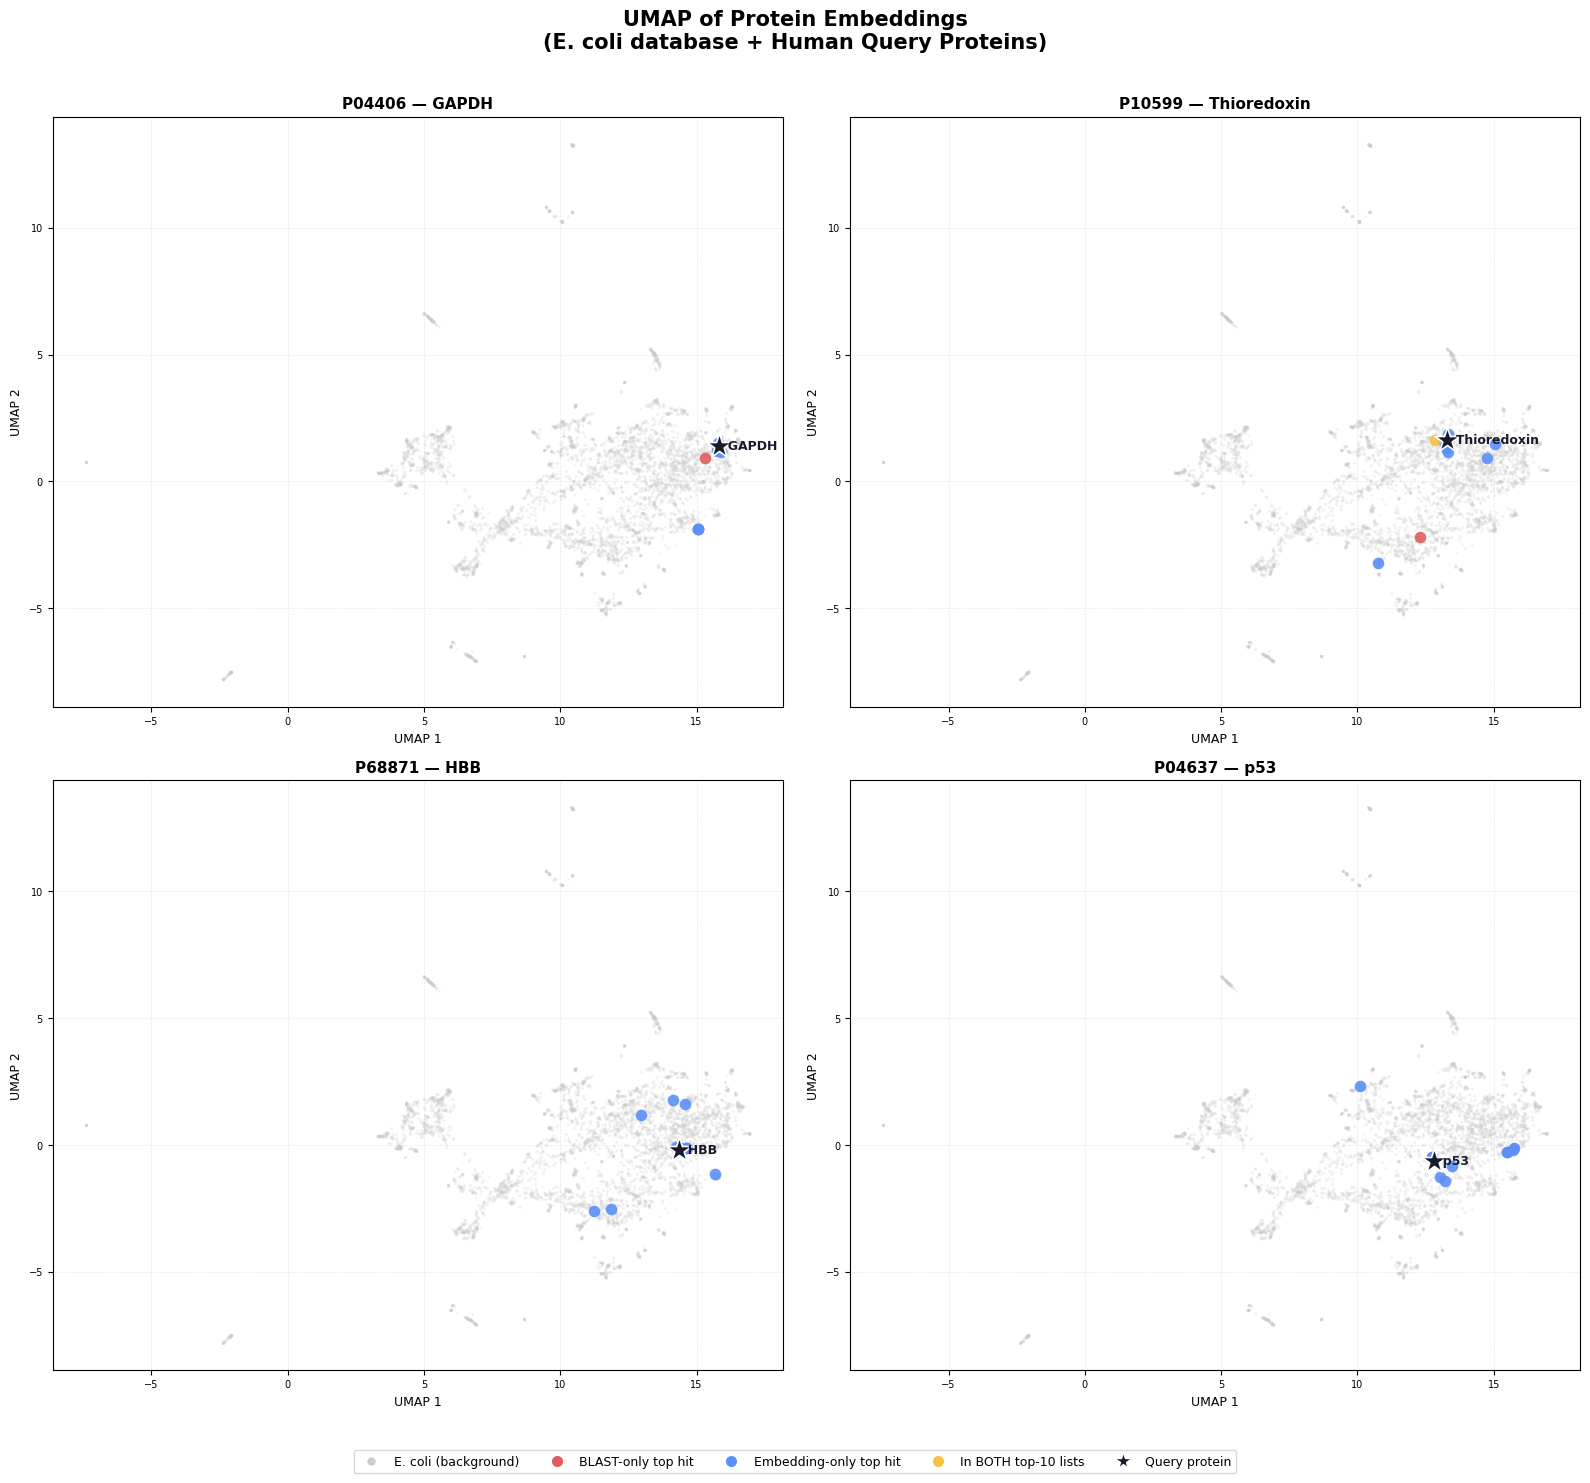

In [17]:
#Exercise 5
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import umap

db_ids     = list(db_embeddings.keys())          # ~4400 E. coli IDs
query_ids  = Prot_IDs
all_ids    = db_ids + query_ids
all_matrix = np.vstack(
    [db_embeddings[i]   for i in db_ids] +
    [query_embeddings[i] for i in query_ids]
)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42, n_jobs=1)
coords_2d = reducer.fit_transform(all_matrix)

n_ecoli     = len(db_ids)
ecoli_coords  = coords_2d[:n_ecoli]
query_coords  = coords_2d[n_ecoli:]
query_labels = {
    'P04406': 'GAPDH',
    'P10599': 'Thioredoxin',
    'P68871': 'HBB',
    'P04637': 'p53',
}

db_id_to_idx = {uid: i for i, uid in enumerate(db_ids)}
COLORS = {
    'background': '#CCCCCC',
    'blast_only': '#E05C5C',    # coral-red
    'emb_only':   '#5B8FF9',    # blue
    'both':       '#F6C244',    # gold
}
MARKER_QUERY = '*'

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('UMAP of Protein Embeddings\n(E. coli database + Human Query Proteins)',
             fontsize=15, fontweight='bold', y=1.01)

for ax, query_id in zip(axes.flatten(), query_ids):
    blast_ids_q = set(alignment_dict.get(query_id, {}).keys())
    emb_ids_q   = set(emb_dict.get(query_id, {}).keys())

    both_q       = blast_ids_q & emb_ids_q
    blast_only_q = blast_ids_q - emb_ids_q
    emb_only_q   = emb_ids_q   - blast_ids_q
    categories = np.array(['background'] * n_ecoli, dtype=object)

    for uid in blast_only_q:
        if uid in db_id_to_idx:
            categories[db_id_to_idx[uid]] = 'blast_only'
    for uid in emb_only_q:
        if uid in db_id_to_idx:
            categories[db_id_to_idx[uid]] = 'emb_only'
    for uid in both_q:
        if uid in db_id_to_idx:
            categories[db_id_to_idx[uid]] = 'both'

    # Plot in layers: background first, then hits on top
    for cat in ['background', 'blast_only', 'emb_only', 'both']:
        mask = categories == cat
        if not mask.any():
            continue
        size   = 5  if cat == 'background' else 70
        zorder = 1  if cat == 'background' else 3
        alpha  = 0.25 if cat == 'background' else 0.9
        ax.scatter(ecoli_coords[mask, 0], ecoli_coords[mask, 1],
                   c=COLORS[cat], s=size, alpha=alpha, linewidths=0,
                   zorder=zorder, rasterized=True)

    # Plot the query protein itself
    q_idx   = query_ids.index(query_id)
    q_coord = query_coords[q_idx]
    ax.scatter(q_coord[0], q_coord[1],
               c='#1A1A2E', s=350, marker=MARKER_QUERY, zorder=5,
               edgecolors='white', linewidths=1.2, label='Query')
    ax.annotate(f"  {query_labels[query_id]}", xy=(q_coord[0], q_coord[1]),
                fontsize=9, fontweight='bold', color='#1A1A2E',
                va='center', zorder=6)

    # Titles and formatting
    ax.set_title(f"{query_id} — {query_labels[query_id]}", fontsize=11, fontweight='bold')
    ax.set_xlabel("UMAP 1", fontsize=9)
    ax.set_ylabel("UMAP 2", fontsize=9)
    ax.tick_params(labelsize=7)
    ax.grid(True, linestyle='--', alpha=0.3, linewidth=0.5)

# ── Legend ────────────────────────────────────────────────────────────────────
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='E. coli (background)',
           markerfacecolor=COLORS['background'], markersize=7),
    Line2D([0], [0], marker='o', color='w', label='BLAST-only top hit',
           markerfacecolor=COLORS['blast_only'], markersize=9),
    Line2D([0], [0], marker='o', color='w', label='Embedding-only top hit',
           markerfacecolor=COLORS['emb_only'], markersize=9),
    Line2D([0], [0], marker='o', color='w', label='In BOTH top-10 lists',
           markerfacecolor=COLORS['both'], markersize=9),
    Line2D([0], [0], marker='*', color='w', label='Query protein',
           markerfacecolor='#1A1A2E', markersize=13),
]
fig.legend(handles=legend_elements, loc='lower center', ncol=5,
           fontsize=9, frameon=True, bbox_to_anchor=(0.5, -0.04))

plt.tight_layout()
plt.savefig('umap_protein_space.png', dpi=150, bbox_inches='tight')
plt.show()


Exercise 5

Interpretation:
Both BLAST and embedding top-10 hits generally cluster near their respective query proteins in UMAP space, confirming that the embedding space captures biologically meaningful proximity.

Exercise 6

Q1: I would trust BLAST over embeddings when I need to verify recent, direct evolutionary descent. For example, confirming that a newly sequenced pathogen strain carries the same resistance gene as a known strain. If sequence identity is >60% and the alignment covers most of the protein, BLAST's answer is precise and interpretable.

Q2: I would use embeddings for convergent evolution of enzyme function. In serine proteases for example, the catalytic triad (Ser-His-Asp) evolved independently in subtilisins, chymotrypsins, and signal peptidases. The sequences are so different that BLAST won't connect them, but a PLM embedding recognizes the shared biochemical properties.

Q3: I would use both for drug discovery. Start with embeddings for discovery to sweep the whole proteome for anything that lands near known virulence factors, essential metabolic enzymes, or validated drug targets in embedding space. This casts the widest net and catches diverged homologs that sequence identity would miss. Then use BLAST to validate and prioritize the hits: check whether candidates share conserved catalytic residues with the known target, estimate how much the binding pocket is likely to be conserved, and rule out proteins that are too similar to human orthologs

Q4: What was surprising was how different Blast and embeddings work even though they try to achieve the same thing.



[Logbook]
One thing that was confusing was giving specific examples on when to use Blast vs embeddings. I felt like the route didn't really explain the differences too well. I used google to explain to me their differences and provide me with specific examples. One thing that I learned about when working with real data was when to use blast vs embeddings. They both achieve the same goal but in different ways which gives different results. I wonder if there are any other methods of finding protein homologs.